#  NEURAL NETWORKS, PROJECT 2: Understanding calibration in *CNNs*


Authors:

Marina Gómez Rey (100472836)

María Ángeles Magro Garrote (100472867)

Ángela Durán Pinto (100472766)

#  Understanding calibration in *CNNs*

In [82]:
#pip install torchviz

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.calibration import calibration_curve
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchviz # for model structure visualization
from torchviz import make_dot
from IPython.display import Image

## Training a Lenet5 CNN

Statement: Train a Lenet5 CNN from scratch to classify birds from cats in CIFAR10. Namely, we only consider two categories. Evaluate the reliability diagram and the ECE in the test set. You have methods for this in sklearn.

### Dataset uploading and selection

For achieving this task, we must only consider bird and cats images.

In [84]:
# Download CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full CIFAR-10 dataset
full_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define bird and cat class indices
bird_class_index = 2  # Bird class index in CIFAR-10
cat_class_index = 3  # Cat class index in CIFAR-10

# Filter out bird and cat images from the full training set
train_bird_indices = [i for i, (image, label) in enumerate(full_train_set) if label == bird_class_index]
train_cat_indices = [i for i, (image, label) in enumerate(full_train_set) if label == cat_class_index]

test_bird_indices = [i for i, (image, label) in enumerate(test_set) if label == bird_class_index]
test_cat_indices = [i for i, (image, label) in enumerate(test_set) if label == cat_class_index]


# Split the filtered indices into training and validation sets
val_split = 0.2  # 20% of the training data will be used for validation
split_idx = int(len(train_bird_indices) * val_split)

train_bird_indices, val_bird_indices = train_bird_indices[split_idx:], train_bird_indices[:split_idx]
train_cat_indices, val_cat_indices = train_cat_indices[split_idx:], train_cat_indices[:split_idx]

# Create subsets for bird and cat datasets for training and validation
train_bird_dataset = torch.utils.data.Subset(full_train_set, train_bird_indices)
train_cat_dataset = torch.utils.data.Subset(full_train_set, train_cat_indices)

val_bird_dataset = torch.utils.data.Subset(full_train_set, val_bird_indices)
val_cat_dataset = torch.utils.data.Subset(full_train_set, val_cat_indices)

test_bird_dataset = torch.utils.data.Subset(test_set, test_bird_indices)
test_cat_dataset = torch.utils.data.Subset(test_set, test_cat_indices)

# Map bird class to label 0 and cat class to label 1
train_bird_dataset = [(image, 0) for image, _ in train_bird_dataset]
train_cat_dataset = [(image, 1) for image, _ in train_cat_dataset]

val_bird_dataset = [(image, 0) for image, _ in val_bird_dataset]
val_cat_dataset = [(image, 1) for image, _ in val_cat_dataset]

test_bird_dataset = [(image, 0) for image, _ in test_bird_dataset]
test_cat_dataset = [(image, 1) for image, _ in test_cat_dataset]

# Combine bird and cat datasets for training and validation
train_dataset = torch.utils.data.ConcatDataset([train_bird_dataset, train_cat_dataset])
val_dataset = torch.utils.data.ConcatDataset([val_bird_dataset, val_cat_dataset])
test_dataset = torch.utils.data.ConcatDataset([test_bird_dataset, test_cat_dataset])

# Define batch size
batch_size = 64

# Create data loaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Datasets analysis

First, it should be check the lenght of our datasets:

In [85]:
# Check the length of train, validation, and test set
print(f"Number of train images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_set)}")

Number of train images: 8000
Number of validation images: 2000
Number of test images: 10000


Furthermore, the image dimensions should be obtained

In [86]:
# Iterate through the training data loader to obtain batches of data
traindata = iter(train_loader)

# Extract the next batch of images and labels from the training data loader
images, labels = next(traindata)

# Print the shape of the second image in the batch
print(images[1].shape)

torch.Size([3, 32, 32])


Also, the filters can be tested to check its correct

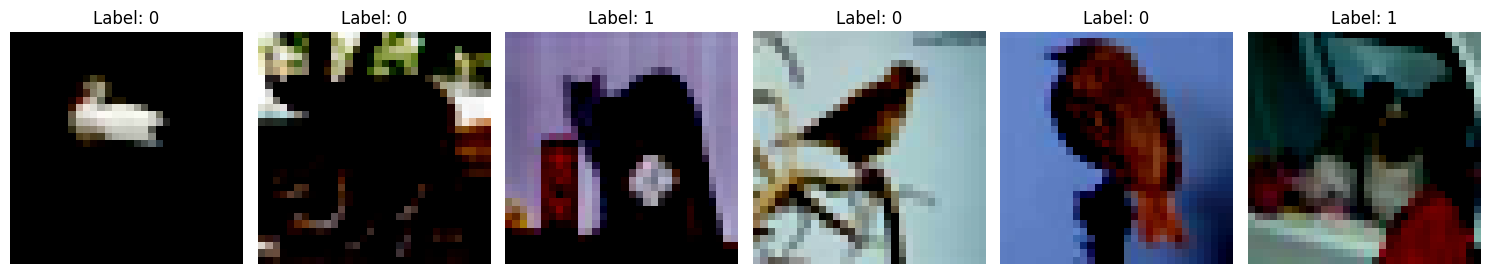

In [87]:
# Get a batch of data from the validation loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Plot the images from the batch
fig, axes = plt.subplots(figsize=(15, 4), ncols=6)

# Loop through the first 6 images in the batch
for ii in range(6):
    ax = axes[ii]

    # Extract and display the image, ensuring it's within the valid range
    ax.imshow(images[ii].numpy().transpose((1, 2, 0)).clip(0, 1))
    ax.set_title(f"Label: {labels[ii]}")  # Set title as label

# Remove any unused subplots
for ax in axes.flat:
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

### Creation of the Lenet5 CNN

In [88]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels):
        super().__init__()

        # convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,
                               kernel_size=5, stride=1, padding=0)

        # convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)

        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        # 16x5x5 = 400
        self.linear1 = nn.Linear(400,120)

        self.linear2 = nn.Linear(120,84)
        # nlabels = 10
        self.linear3 = nn.Linear(84,nlabels)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim=1)


        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)  #((32-4)/2-4)/2=5

    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x)
        return x

In [89]:
class Lenet5_extended_GPU(Lenet5):

    def __init__(self, dimx, nlabels, epochs=100, lr=0.001):
        super().__init__(dimx, nlabels)

        self.lr = lr  # Learning Rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define device
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []

    def trainloop(self, trainloader, validloader):
        best_valid_loss = float('inf')
        patience = 2
        counter = 0

        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.

            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss/len(trainloader))

            with torch.no_grad():
                running_loss = 0.

                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()

                self.valid_loss_during_training.append(running_loss/len(validloader))

                if self.valid_loss_during_training[-1] < best_valid_loss:
                    best_valid_loss = self.valid_loss_during_training[-1]
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience:
                        print("Early stopping at epoch", e)
                        return

            print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                  % (e, self.loss_during_training[-1], self.valid_loss_during_training[-1],
                     (time.time() - start_time)))

            if e == self.epochs - 1:
                print("Last epoch reached!")
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds"
                      % (e, self.loss_during_training[-1], self.valid_loss_during_training[-1],
                         (time.time() - start_time)))

    def eval_performance(self, dataloader):
        loss = 0
        accuracy = 0

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                probs = self.forward(images)
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

                print('True label is ', labels)
                print('Predicted probabilities', probs)

            return accuracy/len(dataloader)


Before continuing, we can check that the dimensions of our CNN have been correctly created.

In [90]:
from torchsummary import summary

# Create an instance of the Lenet5 model
model = Lenet5(dimx=32, nlabels=2)  # 2 output classes for CIFAR-10
summary(model, (3, 32, 32))  # Input shape: (channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                    [-1, 2]             170
       LogSoftmax-12                    [-1, 2]               0
Total params: 61,326
Trainable params: 61,326
Non-trainable params: 0
---------------------------------

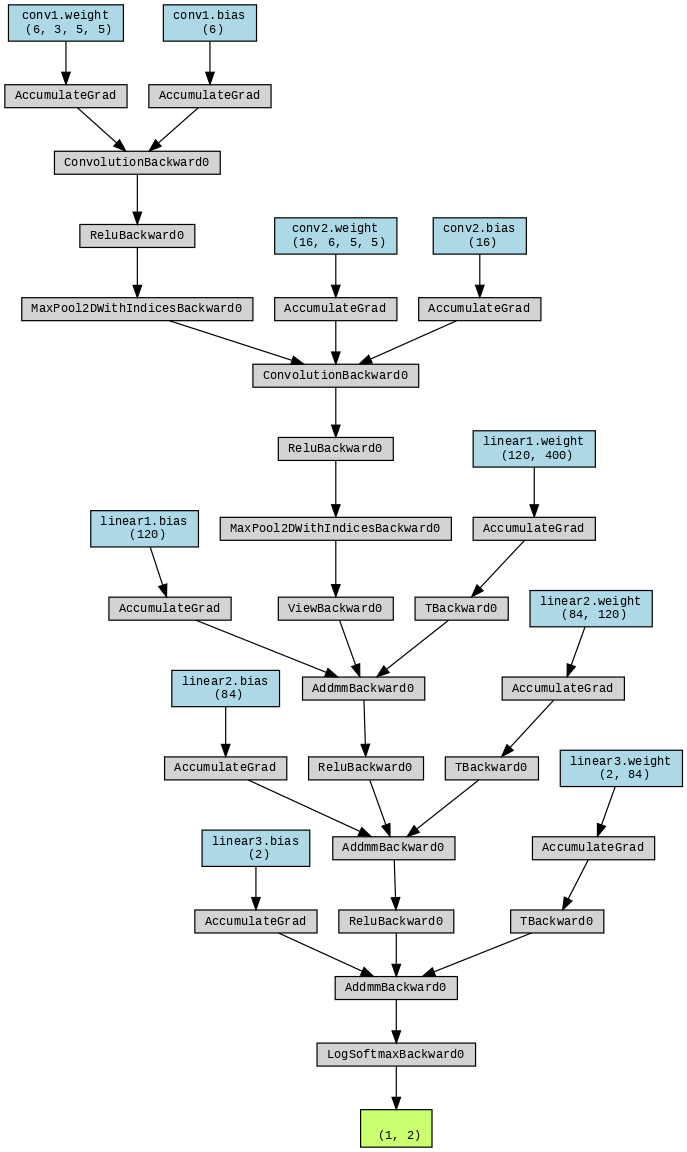

In [91]:
# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 images

# Forward pass through the model to generate the computational graph
output = model(dummy_input)

# Plot the computational graph
graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("lenet5_model", format="png", cleanup=True)  # Save the graph as a PNG file

# Path to display the image
image_path = "lenet5_model.png"

# Display the image
Image(image_path)

Now, we can create the model.

In [92]:
# Creating the Lenet5 CNN
my_CNN = Lenet5_extended_GPU(dimx=32,nlabels=2,epochs=100,lr=1e-3)
my_CNN.trainloop(train_loader,val_loader)

Epoch 0. Training loss: 0.588744, Validation loss: 0.518490, Time per epoch: 4.333716 seconds
Epoch 1. Training loss: 0.510773, Validation loss: 0.491873, Time per epoch: 4.396467 seconds
Epoch 2. Training loss: 0.472672, Validation loss: 0.470643, Time per epoch: 4.275782 seconds
Epoch 3. Training loss: 0.446542, Validation loss: 0.459681, Time per epoch: 2.355778 seconds
Epoch 4. Training loss: 0.426022, Validation loss: 0.454578, Time per epoch: 2.328388 seconds
Epoch 5. Training loss: 0.409182, Validation loss: 0.442770, Time per epoch: 2.753814 seconds
Epoch 6. Training loss: 0.383103, Validation loss: 0.473908, Time per epoch: 2.603518 seconds
Epoch 7. Training loss: 0.367044, Validation loss: 0.437051, Time per epoch: 2.318971 seconds
Epoch 8. Training loss: 0.341115, Validation loss: 0.437001, Time per epoch: 2.354068 seconds
Epoch 9. Training loss: 0.322401, Validation loss: 0.437222, Time per epoch: 2.347419 seconds
Early stopping at epoch 10


The performance during this training can be illustrated throughout a plot.

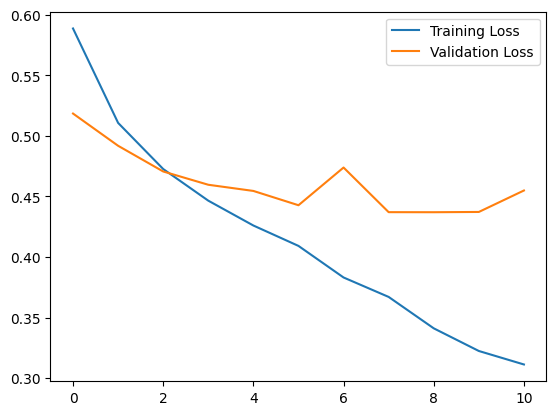

In [93]:
plt.plot(my_CNN.loss_during_training,label='Training Loss')
plt.plot(my_CNN.valid_loss_during_training,label='Validation Loss')
plt.legend()

## Reliability diagram


A reliability diagram, also known as a calibration plot, is a graphical tool used to assess the calibration of probabilistic predictions made by a classification model. It helps visualize how well the predicted probabilities align with the actual observed frequencies of the positive class across different ranges of predicted probabilities.

Explanation of Inputs:

* y_true: This refers to the true labels or targets of the samples in your dataset.

* y_prob: Represents the predicted probabilities of the positive class for each sample in your dataset. For binary classification, y_prob should be an array-like object (e.g., a numpy array or a list) containing the predicted probabilities of the positive class for each sample.

* pos_label: Specifies the label of the positive class.
Explanation of Outputs:

Explanation of outputs:

* prob_true: An ndarray of shape (n_bins,) or smaller, representing the proportion of samples whose class is the positive class in each bin (fraction of positives).

* prob_pred: An ndarray of shape (n_bins,) or smaller, representing the mean predicted probability in each bin.


In [94]:
def plot_reliability_diagram(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, pos_label=0, n_bins=n_bins, strategy='quantile')
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Empirical Probability')
    plt.title('Reliability Diagram')
    plt.show()
    return prob_true, prob_pred

def get_y_true_y_prob(model, test_loader):
    # Set model to evaluation mode
    model.eval()

    # Initialize lists to store true labels and predicted probabilities
    y_true = []
    y_prob = []

    # Predict probabilities on the test set
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model.forward(images)
            probabilities = nn.functional.softmax(outputs, dim=1)
            y_true.extend(labels.numpy())
            y_prob.extend(probabilities.numpy()[:, 0])  # Probability of being in positive class 0 (bird)

    return y_true, y_prob

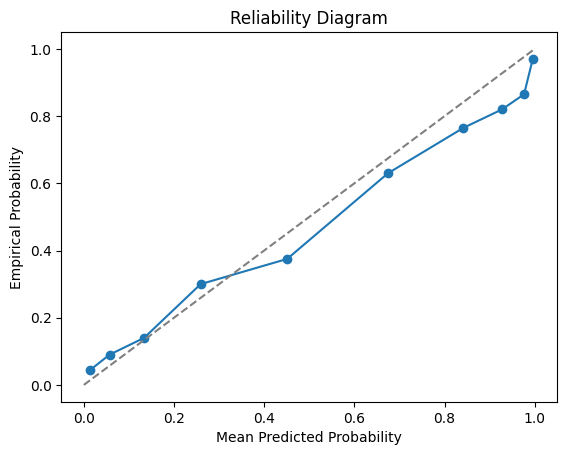

In [95]:
y_true, y_prob = get_y_true_y_prob(my_CNN, test_loader)
prob_true, prob_pred = plot_reliability_diagram(y_true, y_prob, n_bins=10)

## ECE

Expected Calibration Error (ECE) is a metric used to evaluate the calibration of probabilistic predictions made by a machine learning model. Calibration refers to the agreement between the predicted probabilities and the true probabilities of the predicted outcomes.

The ECE formula is the following one:

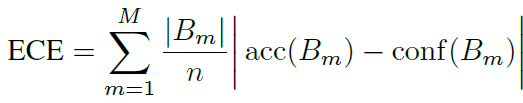

In order to avoid redoing a lot of calculations, we took advantage of the alredy calculated y_prob, prob_true and prob_pred, where:

* prob_pred is a vector containing the confidences, which represent the mean predicted probabilities within each bin.

* prob_true is a vector containing the accuracies for each bin, which represent the proportion of correctly predicted samples within each bin.


In [96]:
def ece_cal(y_prob,prob_true, prob_pred, n_bins=10):
# Determine the number of samples
    n = len(y_prob)

    # Calculate the size of each bin
    bin_size = n / n_bins

    # Initialize the variable to store the final ECE value
    final_ece = 0

    # Loop over each bin
    for m in range(n_bins):
        # Calculate the absolute difference between the true probability and the predicted probability
        # and scale it by the size of the bin and the total number of samples (FORMULA)
        final_ece += np.abs(prob_true[m] - prob_pred[m]) * bin_size / n

    # Return the computed ECE
    return final_ece

In [97]:
ece = ece_cal(y_prob,prob_true, prob_pred, n_bins=10)
print(ece)

0.05523684605913879


## Platt Scaling

Temperature scaling is a technique used for calibrating probabilistic models by adjusting the confidence predictions based on logits. It employs a scalar parameter T to soften the softmax function, increasing output entropy with T > 1. By optimizing T through the Negative Log-Likelihood (NLL) on the validation set, temperature scaling ensures that while the probability distribution's entropy changes, the accuracy of class predictions remains unaffected.

### 1) Optimizing temperature

The ModelWithTemperature class implements a method to find the best temperature parameter that scales the logits of the original model to improve the calibration of the predicted probabilities.

1) The ModelWithTemperature class initializes with a temperature parameter (self.temperature) that is set as a learnable parameter using nn.Parameter(torch.ones(1) * 1.5). This initializes the temperature with a value of 1.5.

2) During the forward pass, the input is passed through the original model (self.model) to obtain logits (unnormalized probabilities).
The logits are then scaled by dividing them by the temperature parameter. This scaling operation adjusts the "temperature" of the softmax function.

3) The set_temperature method optimizes the temperature parameter using the negative log likelihood (NLL) loss on the validation data. It calculates the NLL loss before and after temperature scaling to assess the calibration improvement.

In summary, the model finds the best temperature by iteratively adjusting the temperature parameter to minimize the NLL loss on the validation set.

In [98]:
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    def set_temperature(self, valid_loader):
        # nn.CrossEntropyLoss() calculates the negative log likelihood (NLL) loss.
        nll_criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam([self.temperature], lr=0.01)

        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list)
            labels = torch.cat(labels_list)

        before_temperature_nll = nll_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f' % before_temperature_nll)

        def closure():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss

        optimizer.step(closure)

        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f' % after_temperature_nll)

        # Save the best temperature
        self.best_temperature = self.temperature.item()

        return self

# Using our original model my_CNN
temp_scaled_model = ModelWithTemperature(my_CNN)

# Set the temperature using validation data
temp_scaled_model.set_temperature(val_loader)

# Access and use the best temperature
best_temperature = temp_scaled_model.best_temperature


Before temperature - NLL: 0.455
Optimal temperature: 1.490
After temperature - NLL: 0.434


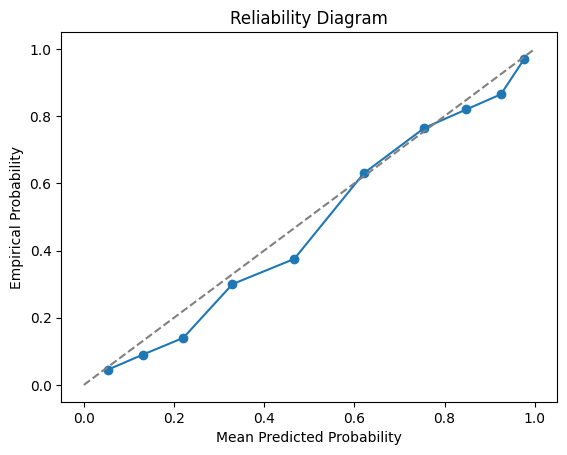

ECE after temperature scaling: 0.03639343815227041


In [99]:
# Evaluate performance
y_true_temp_scaled, y_prob_temp_scaled = get_y_true_y_prob(temp_scaled_model, test_loader)
prob_true_temp_scaled, prob_pred_temp_scaled = plot_reliability_diagram(y_true_temp_scaled, y_prob_temp_scaled, n_bins=10)

# Calculate ECE after temperature scaling
ece_temp_scaled = ece_cal(y_prob_temp_scaled, prob_true_temp_scaled, prob_pred_temp_scaled, n_bins=10)
print("ECE after temperature scaling:", ece_temp_scaled)

### 2) Testing manually temperatures

Furthermore, the reliability diagram can be plotted with other temperatures

TEMPERATURE 0.3


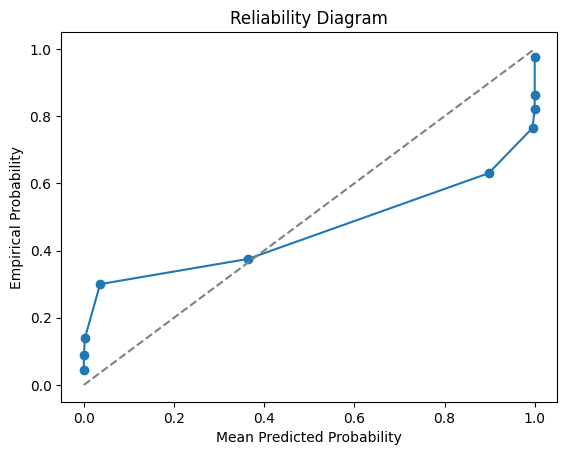

ECE 0.1387402597871611
 
TEMPERATURE 0.75


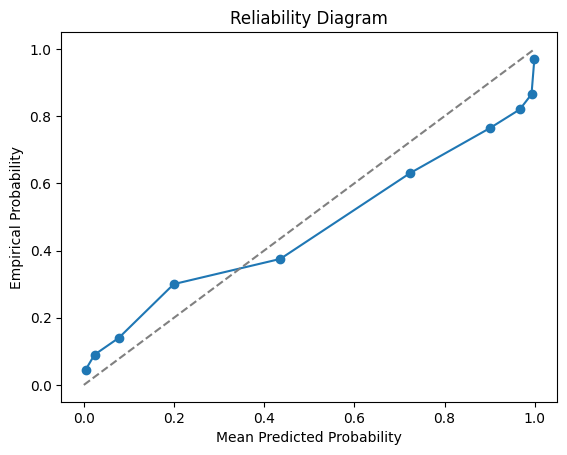

ECE 0.08643906969990352
 
TEMPERATURE 1.12


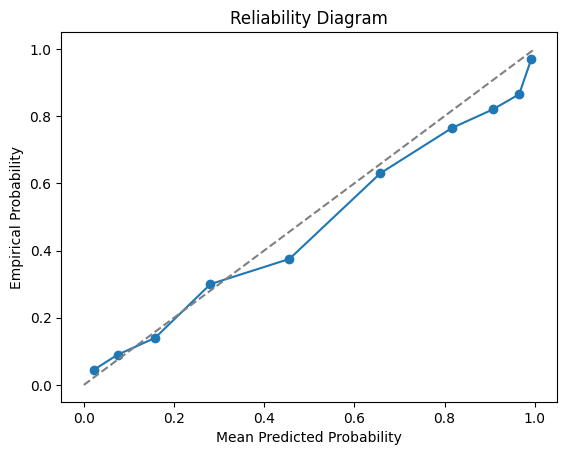

ECE 0.044552148134476735
 
TEMPERATURE 1.4900000095367432


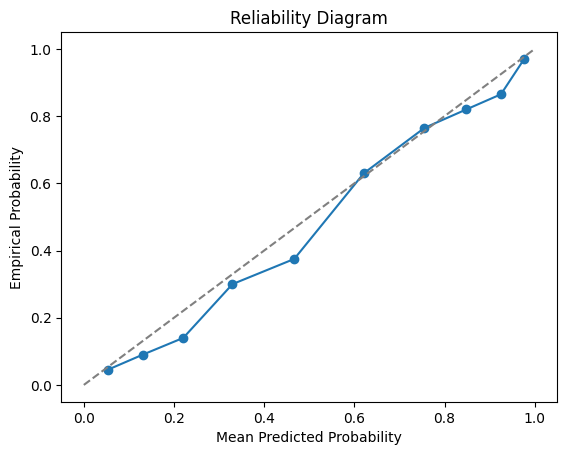

ECE 0.03639343767217361
 
TEMPERATURE 1.79


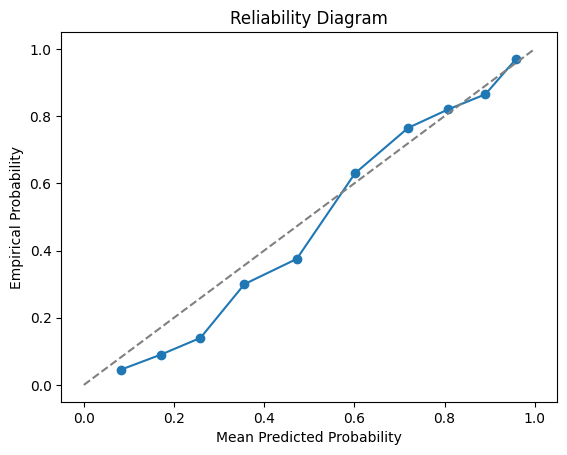

ECE 0.05123941403534264
 
TEMPERATURE 2.24


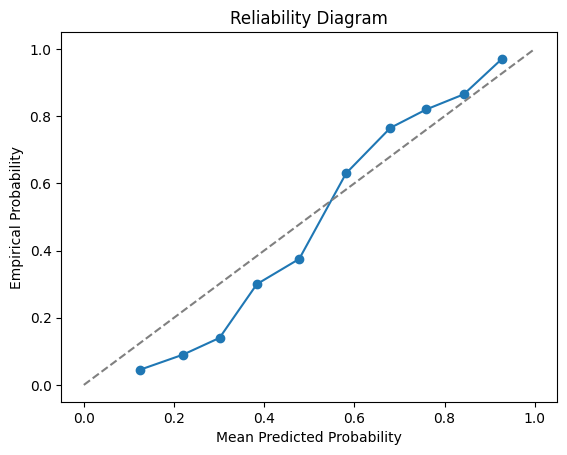

ECE 0.08156184385623781
 
TEMPERATURE 2.61


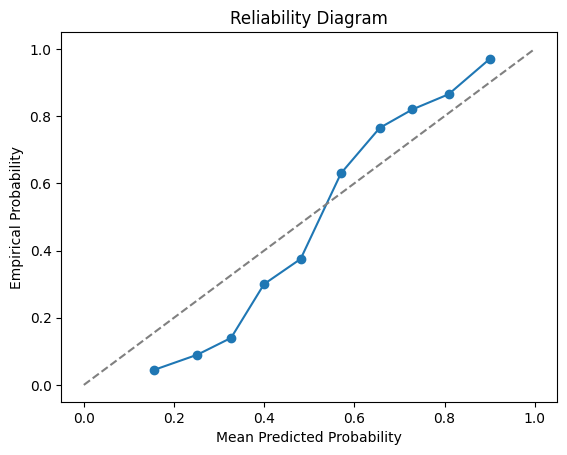

ECE 0.10511554709635672
 


In [100]:
def temperature_scaling(logits, temperature):
    scaled_probs = torch.exp(logits / temperature) / torch.sum(torch.exp(logits / temperature), dim=1, keepdim=True)
    return scaled_probs

def apply_scaling(model, test_loader, temperature):
    # Set model to evaluation mode
    model.eval()

    # Initialize lists to store true labels and scaled probabilities
    y_true = []
    scaled_probs = []

    # Predict logits on the test set
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model.forward(images)
            scaled_probabilities = temperature_scaling(outputs, temperature)
            y_true.extend(labels.numpy())
            scaled_probs.extend(scaled_probabilities.numpy()[:, 0])  # Probability of being in positive class 0 (bird)

    return y_true, scaled_probs

# Define a function to study the effect of temperature scaling
def study_temperature_scaling(model, test_loader, temperatures):
    eces = []
    prob_true_all = []
    prob_pred_all = []
    for temp in temperatures:
        print("TEMPERATURE", temp)
        # Apply temperature scaling
        y_true, scaled_probs = apply_scaling(model, test_loader, temp)

        # Collect probabilities for reliability diagram
        prob_true, prob_pred = plot_reliability_diagram(y_true, scaled_probs, n_bins=10)
        prob_true_all.append(prob_true)
        prob_pred_all.append(prob_pred)

        # Calculate ECE
        ece = ece_cal(scaled_probs, prob_true, prob_pred, n_bins=10)
        print("ECE", ece)
        print(" ")
        eces.append(ece)

    return eces, prob_true_all, prob_pred_all

# Round the temperatures to two decimal places
smaller_temperatures = [round(best_temperature * 0.2, 2), round(best_temperature * 0.5, 2), round(best_temperature * 0.75, 2)]
bigger_temperatures = [round(best_temperature * 1.2, 2), round(best_temperature * 1.5, 2), round(best_temperature * 1.75, 2)]

# Combine smaller and bigger temperatures into one list
temperatures = smaller_temperatures + [best_temperature] + bigger_temperatures

# Get ECE values and reliability diagrams
eces, prob_true_all, prob_pred_all = study_temperature_scaling(my_CNN, test_loader, temperatures)

We can group all this information in less plots: one grouping all the reliability diagrams and other for the ECE for each temperature.

In [101]:
print(temperatures, eces)

[0.3, 0.75, 1.12, 1.4900000095367432, 1.79, 2.24, 2.61] [0.1387402597871611, 0.08643906969990352, 0.044552148134476735, 0.03639343767217361, 0.05123941403534264, 0.08156184385623781, 0.10511554709635672]


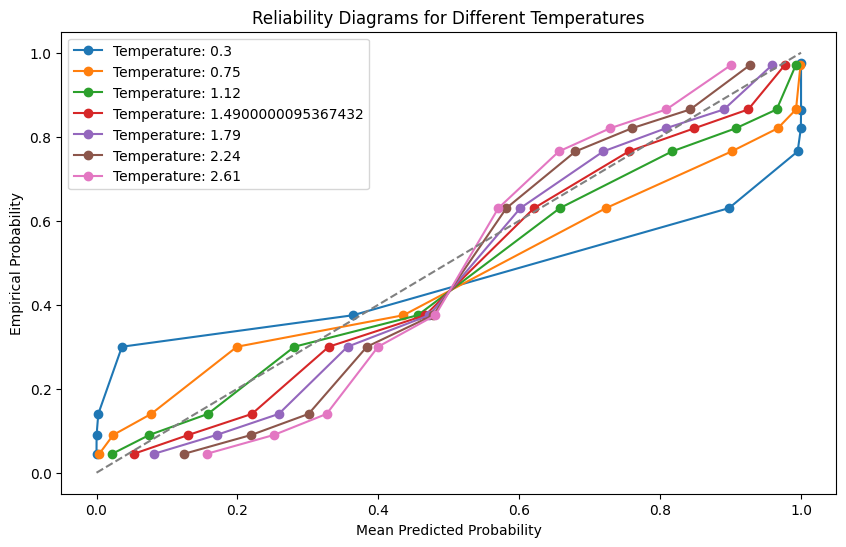

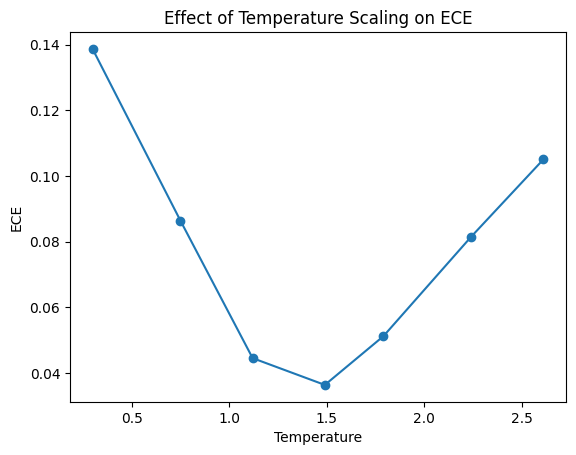

In [102]:
# Plot reliability diagrams together
plt.figure(figsize=(10, 6))
for prob_true, prob_pred, temp in zip(prob_true_all, prob_pred_all, temperatures):
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f'Temperature: {temp}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Empirical Probability')
plt.title('Reliability Diagrams for Different Temperatures')
plt.legend()
plt.show()

# Plot ECE values in a line plot
plt.plot(temperatures, eces, marker='o', linestyle='-')
plt.xlabel('Temperature')
plt.ylabel('ECE')
plt.title('Effect of Temperature Scaling on ECE')
plt.show()


This corresponds with the temperature optimization that has been done previously.

## Part 3: Bigger model


Now we are going to fine-tuning a pre-trained model which involves adjusting the parameters of the model to adapt it to a new dataset while leveraging the knowledge learned from the original dataset.

First, we need to load the pre-trained model, we are going to use DenseNet which has been trained on a large dataset ImageNet. This model comes with pre-trained weights that capture useful features from the original dataset.

In [103]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In order to be able to use the pre-trained DenseNet model, which expects input images of 224x224 dimensions, with our CIFAR-10 dataset where images are 32x32, we need to perform several adjustments. Firstly, we resize our images to match the expected input size. Additionally, to ensure consistency in normalization, we apply the same normalization parameters used during training of the DenseNet model. This ensures that the input data distribution aligns with the distribution observed during training.

Furthermore, to enhance the model's robustness and improve performance, data augmentation transformations are introduced in the training set. These transformations include random rotation, random resized crop, and random horizontal flip. By introducing these transformations, we aim to increase the diversity of the training data, enabling the model to learn more robust and generalizable features.

In [104]:
# Train Set
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Test Set
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_dataset.transform = train_transforms
val_dataset.transform = test_transforms
test_dataset.transform = test_transforms

# Create data loaders for train, validation, and test sets with data augmentation transformations
train_loader2 = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader2 = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader2 = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Given that the DenseNet model we are employing was initially trained on a dataset with a different number of classes, it's necessary to **replace the final classifier layer** to adapt it to our specific task of classifying birds from cats in the CIFAR-10 dataset. This process involves removing the original fully connected layer, which was tailored for the original classification task, and replacing it with a new classifier. The new classifier is designed to accommodate the unique characteristics of our dataset, specifically with output units corresponding to the two classes present in our dataset: birds and cats.

In [105]:
class MLP(nn.Module):
    def __init__(self,dimx=1024,hidden=500,nlabels=2):

        super().__init__()

        self.output1 = nn.Linear(dimx,hidden)

        self.output2 = nn.Linear(hidden,nlabels)

        self.relu = nn.ReLU()

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.logsoftmax(x)
        return x

To prevent the pre-trained convolutional layers from being drastically altered during the initial training, we are freeze them, meaning their weights are not updated during training. This allows the model to retain the features learned from the original dataset while only adjusting the weights of the newly added classifier.

In [106]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

classifier = MLP(1024)

model.classifier = classifier

Then, the model is trained on the new dataset. During training, only the parameters of the newly added classifier are updated, while the weights of the frozen convolutional layers remain unchanged. This process helps the model learn to extract features relevant to the new dataset while preserving the valuable knowledge encoded in the pre-trained layers.

In [107]:
class Tran_Eval():


    def __init__(self,model,maxiter=500,lr=0.001):

        self.model = model

        self.lr = lr #Learning Rate

        self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)

        self.max_iter = maxiter

        self.criterion = nn.NLLLoss()

        # A list to store the loss evolution along training

        self.loss_during_training = []

        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)

    def trainloop(self,trainloader):

        # Optimization Loop

        it_images = iter(trainloader)

        running_loss = 0.

        self.model.train()

        for e in range(int(self.max_iter)):


            images,labels = next(it_images)


            # Move input and label tensors to the default device
            images, labels = images.to(self.device), labels.to(self.device)

            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = self.model.forward(images) #YOUR CODE HERE


            loss = self.criterion(out,labels) #YOUR CODE HERE

            running_loss = loss.item()

            #Your code here
            loss.backward()

            #Your code here
            self.optim.step()

            self.loss_during_training.append(running_loss)

            print('Batch %d of %d finished. Loss %f' %(e,self.max_iter,running_loss))


    def eval_performance(self,dataloader,num_batches):

        accuracy = 0

        it_images = iter(dataloader)

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            self.model.eval()

            for e in range(int(num_batches)):

                print('Batch %d of %d' %(e,num_batches))

                images,labels = next(it_images)

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  #YOUR CODE HERE
                probs = self.model.forward(images) #YOUR CODE HERE

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return accuracy/num_batches

In [108]:
model_with_train = Tran_Eval(model,maxiter=10)

In [109]:
model_with_train.trainloop(train_loader2)

Batch 0 of 10 finished. Loss 0.741251
Batch 1 of 10 finished. Loss 0.822107
Batch 2 of 10 finished. Loss 0.613092
Batch 3 of 10 finished. Loss 0.619564
Batch 4 of 10 finished. Loss 0.668630
Batch 5 of 10 finished. Loss 0.610942
Batch 6 of 10 finished. Loss 0.613629
Batch 7 of 10 finished. Loss 0.610194
Batch 8 of 10 finished. Loss 0.509144
Batch 9 of 10 finished. Loss 0.593181


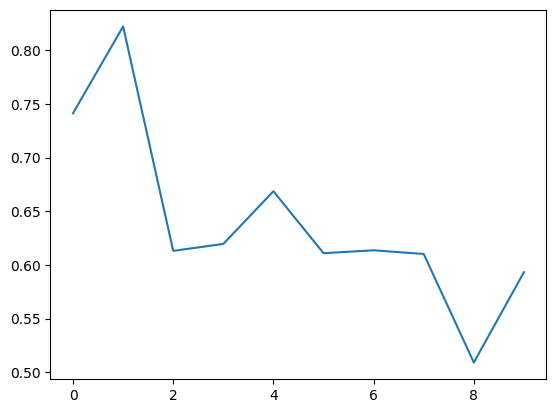

In [110]:
plt.plot(model_with_train.loss_during_training)

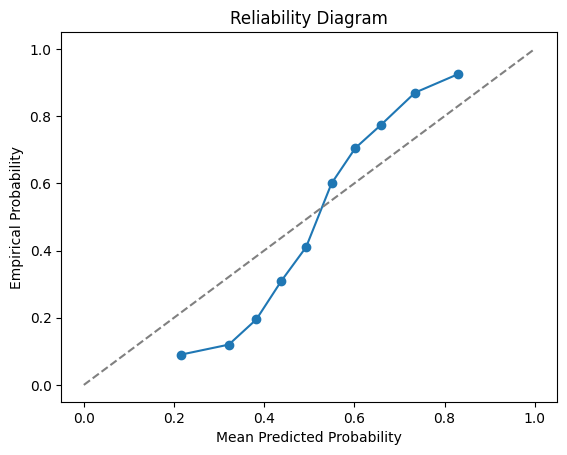

In [111]:
y_true2, y_prob2 = get_y_true_y_prob(model_with_train.model, test_loader2)
prob_true2, prob_pred2 = plot_reliability_diagram(y_true2, y_prob2, n_bins=10)

In [112]:
ece2 = ece_cal(y_prob2,prob_true2, prob_pred2, n_bins=10)
print(ece2)

0.1224076296761632


We can see in the reliaibility diagram as well in the value of ECE, that this bigger model is much worse callibrated

Now, we calibrate our model, tryring several temperatures, and we find the T=0.5 is the best one.

TEMPERATURE 0.3


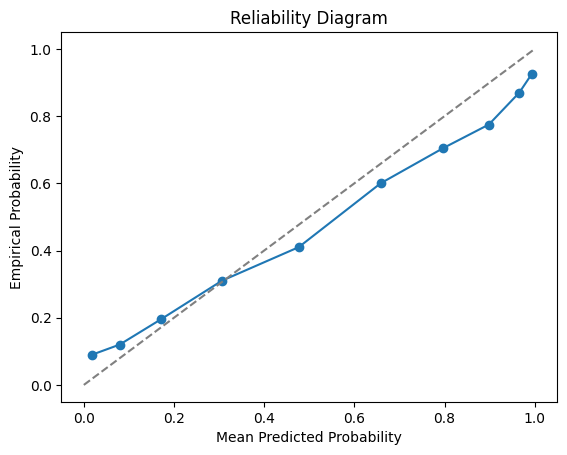

ECE 0.0644881105269269
 
TEMPERATURE 0.4


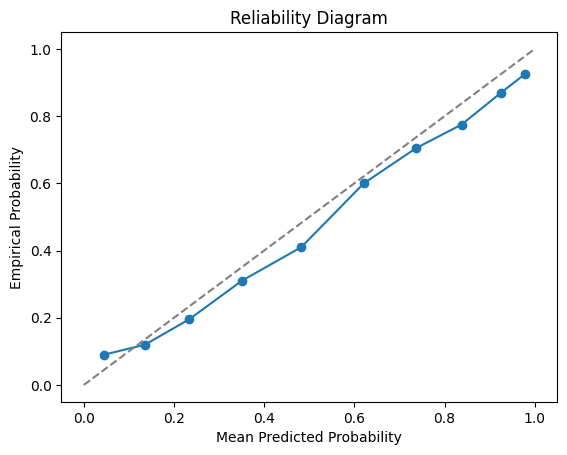

ECE 0.04367544249343336
 
TEMPERATURE 0.5


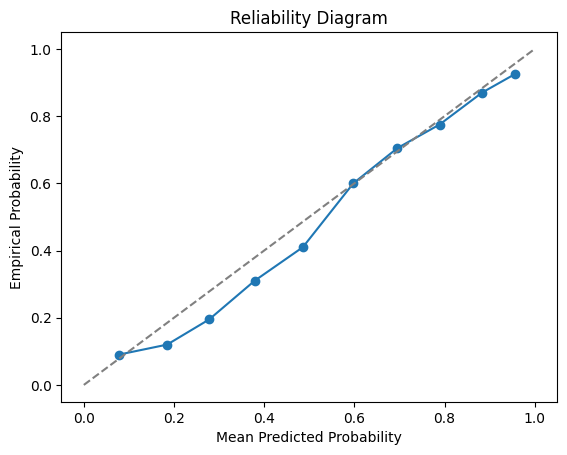

ECE 0.03753321895434054
 
TEMPERATURE 0.6


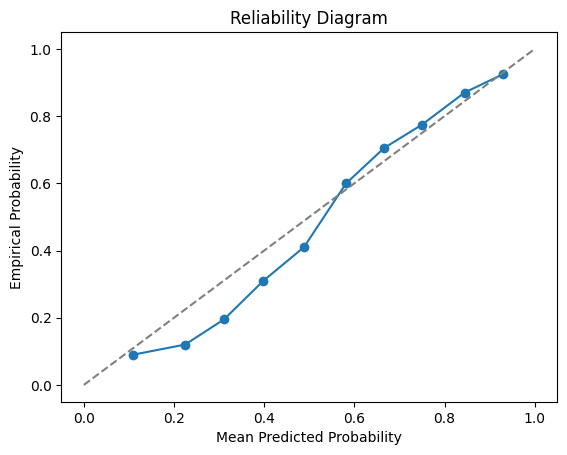

ECE 0.05188574177701956
 
TEMPERATURE 0.75


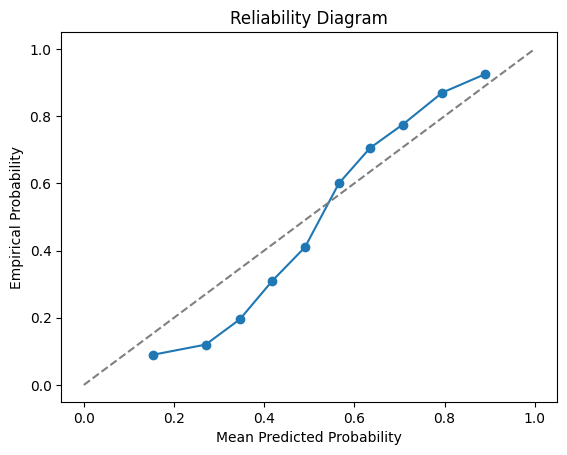

ECE 0.08362011290062217
 
TEMPERATURE 1.25


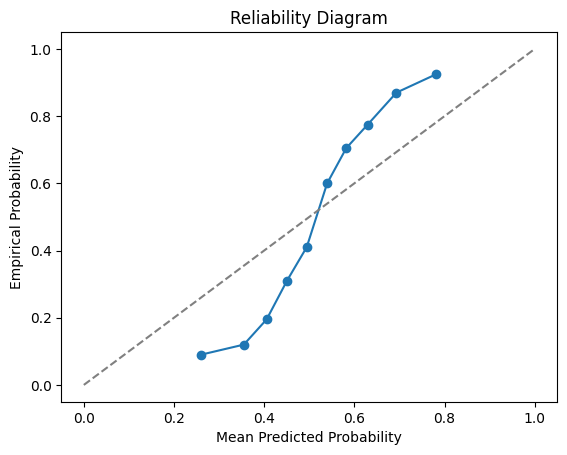

ECE 0.14884070938825608
 
TEMPERATURE 1.5


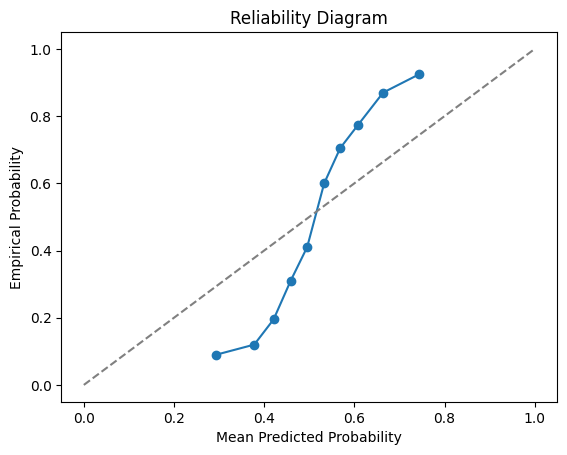

ECE 0.16779288881644608
 


In [122]:
temperatures = [0.3,0.4,0.5,0.6, 0.75,1.25,1.5]

# Get ECE values and reliability diagrams
eces2, prob_true_all2, prob_pred_all2 = study_temperature_scaling(model_with_train.model, test_loader2, temperatures)

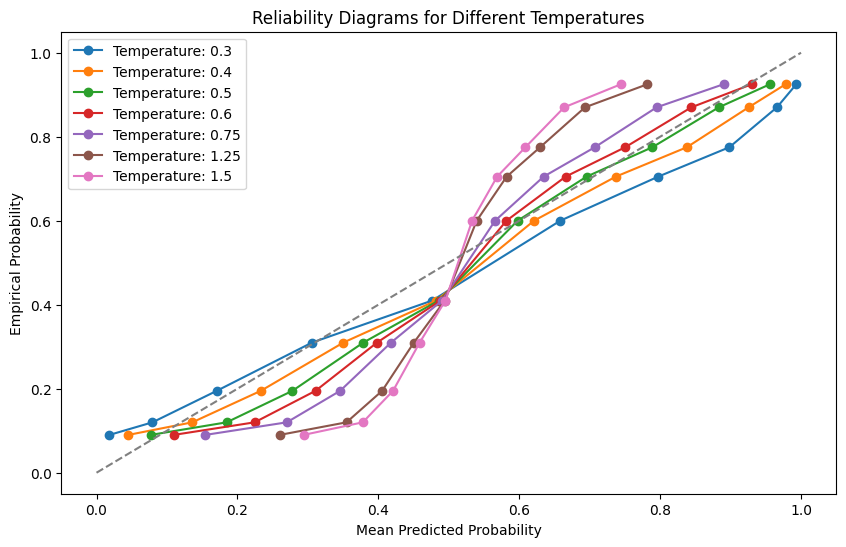

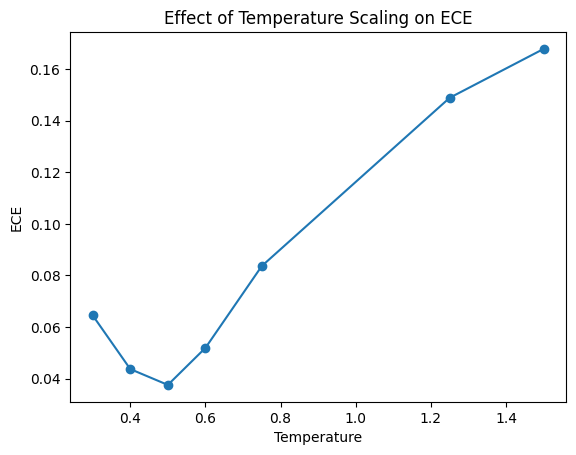

In [124]:
# Plot reliability diagrams together
plt.figure(figsize=(10, 6))
for prob_true, prob_pred, temp in zip(prob_true_all2, prob_pred_all2, temperatures):
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=f'Temperature: {temp}')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Empirical Probability')
plt.title('Reliability Diagrams for Different Temperatures')
plt.legend()
plt.show()

# Plot ECE values in a line plot
plt.plot(temperatures, eces2, marker='o', linestyle='-')
plt.xlabel('Temperature')
plt.ylabel('ECE')
plt.title('Effect of Temperature Scaling on ECE')
plt.show()
